<a href="https://colab.research.google.com/github/ecristallini/FBF/blob/main/FBF_all_in_one_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***A review of velocity fields in fault bend kinematik models***

***All-in-one algorithm for computational application***


Ernesto Cristallini

This code is related to the manuscript presented to to journal xxx

***Figure 1***

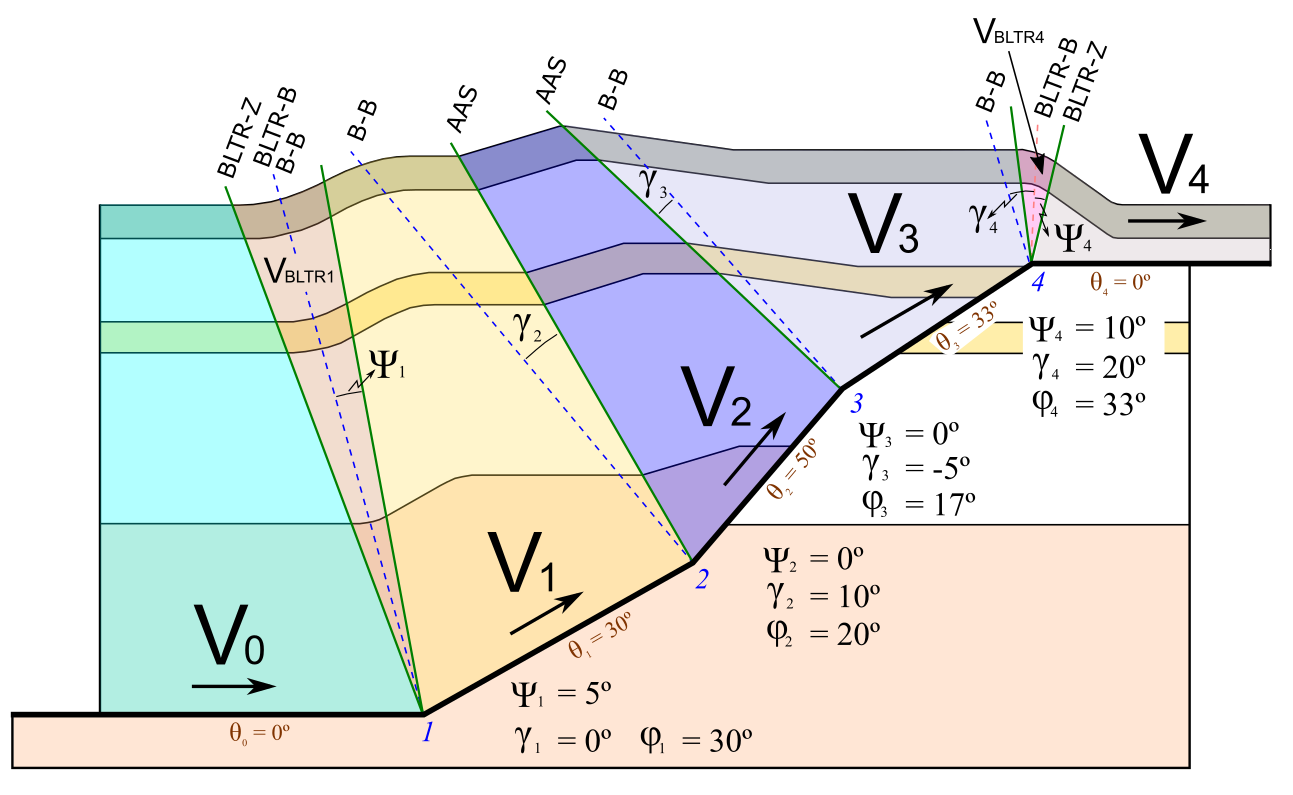

V0 to V1 are the velocities in the non-trishear panels

VBLTR1 and VBLTR4 are the velocities in the backlimb-trishear panels

BLTR-Z are the backlimb trishear boundaries

BLTR-B are the backlimb trishear bisectors

B-B are the fault bend bisectores

AAS are the active axial surfaces (lines in 2D)

In [1]:
import numpy as np
import matplotlib.pylab as plt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

***Setup of the model***

In [2]:
#model boundaries

model_top=500
model_bottom=-150
model_left=0
model_right=800

In [3]:
#Fault plane definition
#In this cell the vertex points of the fault polyline are difined

F_x=[] #List definition of fault vertex x position
F_y=[] #List definition of fault vertex x position

#Replace the values ​​with the x and y of each vertex. In this case the fault of figure 1 has 4 vertices (points 1 to 4) and two ends (points 0 and 5).

#point 0
F_x.append(0)
F_y.append(0)

#point 1
F_x.append(300)
F_y.append(0)

#point 2
F_x.append(500)
F_y.append(100)

#point 3
F_x.append(600)
F_y.append(230)

#point 4
F_x.append(730)
F_y.append(320)

#point 5
F_x.append(900)
F_y.append(320)


In [4]:
#Beds plane definition
#In this cell the bed tops are difined.

b=[]#List definition of bed tops

#Replace the values ​​with tops of undeformed beds. In this case 10 beds are defined.

b.append(-50)
b.append(-5)
b.append(40)
b.append(85)
b.append(130)
b.append(175)
b.append(220)
b.append(265)
b.append(310)
b.append(355)



In [5]:
#Slip
#In this cell the total imput slip and the slip in each step of the model are defined. Set both to negative for normal faults.

totalSlip=80
stepSlip=2


In [6]:
#Asymmetry Type
#The asymmetry type to be used in the model is defined
#FPF: fault-parallel flow
#ISH: inclined shear
#CFBF: classical fault-bend folding (Suppe, 1983 equations)
#user: the asymmetry in each bend is given by the user (case of figure 1)
#If FPF, ISH or CFBF, are selected, asymmetry will be automaticali calculated to achive these models
#CFBF equation (Suppe, 1983) has not results for all combinations of bend angles (Phi) and cut off angles (Theta). See figure 1.

asymmetry_type="user"
ISH_angle=0 # valid only if ISH is choosed for asymmetry_type

In [7]:
#Bending parameters
#In this cell the parameters of fault bends (see previous figure 1 for reference) are defined
#Gammas will be overewriten if FPF, ISH or CFBF is used as asymmetry type

Psi=[] #List definition of PSI half BLTR angle (psi angle is allwais positive)
Gamma=[]

#(see previous figure 1 for reference)

#bend 0 (It is the leftmost vertex of the fault, is not used as a bend, values ​​do not matter)
Psi.append(0)
Gamma.append(0)

#bend 1
Psi.append(5) #5
Gamma.append(0) #0

#bend 2
Psi.append(0) #0
Gamma.append(10) #10

#bend 3
Psi.append(0) #0
Gamma.append(-5) #-5

#bend 4
Psi.append(10) #10
Gamma.append(20) #20


***Model building - classes and functions definition***

***Classes definition***

In [8]:
#This class define a bed and samples it in 500 nodes in order to deform it
class bed(object):
    """"Bed class"""
    def __init__(self,height, color):
        # self.n_points=n_points
        self.color=color
        self.x=np.linspace(model_left,model_right,500) #500 points in each bed
        self.y=np.linspace(height,height,500) #500 points in each bed


In [9]:
#This class draw the model
class drawFigure(object):
     def __init__(self, title):
      for i in range (0,len(b),1):
        plt.plot(bedd[i].x, bedd[i].y)

      plt.plot(F_x, F_y, color='black', linewidth=4)
      plt.axis('equal')
      plt.title(title)
      plt.show()


In [10]:
#This class return the fault bisector in a fault bend
class fault_bisector(object):
     def __init__(self, n_bend):
       # Define fault vectors
        v1 = np.array([F_x[n_bend-1]-F_x[n_bend], F_y[n_bend-1]-F_y[n_bend]])
        v2 = np.array([F_x[n_bend+1]-F_x[n_bend], F_y[n_bend+1]-F_y[n_bend]])

        # Normalizes fault vectors
        v1_norm = v1 / np.linalg.norm(v1)
        v2_norm = v2 / np.linalg.norm(v2)


        # Bisector vector
        self.bisector = v1_norm + v2_norm




In [11]:
#This class return the asymmetry for inclined shear modeling
#Inclined shear angle (angle_ish) must be input
class ISH_asymmetry(object):
     def __init__(self, angle_ish, n_bend):

      bend_sign=np.sign(((F_y[n_bend+1]-F_y[n_bend])/(F_x[n_bend+1]-F_x[n_bend]))-((F_y[n_bend]-F_y[n_bend-1])/(F_x[n_bend]-F_x[n_bend-1]))) #Positive value indicates syncline bend of the fault. Negative value indicates anticline bend of the fault.


      v1=np.array([np.sin(angle_ish), np.cos(angle_ish)]) *bend_sign
      v2=fault_bisector(n_bend).bisector

      angle_between_vectos = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
      self.asymmetry=angle_between_vectos


In [12]:
#This class return the asymmetry for CFBF modeling (Suppe, 1983 equations)
#Cut off angle (tita1) and fault bend angle (phi) must be input (see figure 1)
class CFBF_asymmetry(object):
     def __init__(self, tita1, phi, n_bend):

      bend_sign=np.sign(((F_y[n_bend+1]-F_y[n_bend])/(F_x[n_bend+1]-F_x[n_bend]))-((F_y[n_bend]-F_y[n_bend-1])/(F_x[n_bend]-F_x[n_bend-1]))) #Positive value indicates syncline bend of the fault. Negative value indicates anticline bend of the fault.

      tita1=tita1*(bend_sign)

      minors=[]

      minors.append([999, 0])
      minors.append([999, 0])
      minors.append([999, 0])
      minors.append([999, 0])

      for angle in range(0, 900, 1):

        gamma_suppe = (angle/10)*np.pi/180

        #Suppe (1983) equation
        phi_calculated = (-np.sin(gamma_suppe - tita1) * (np.sin(2 * gamma_suppe - tita1) - np.sin(tita1))) / ((np.cos(gamma_suppe - tita1) * (np.sin(2 * gamma_suppe - tita1) - np.sin(tita1))) - np.sin(gamma_suppe))

        phi_calculated = np.arctan(phi_calculated)

        diference = abs(phi - abs(phi_calculated))

        for j in range(0,len(minors),1):
          if diference < minors[j][0]:
            minors[j][0]=diference
            minors[j][1]=gamma_suppe
            break

      gamma_selected=-999

      for g in minors:
        if g[1]>gamma_selected:
          gamma_selected=g[1]

      print(gamma_selected*180/np.pi)

      inclination=abs((np.pi/2)-gamma_selected)*(-bend_sign)

      self.asymmetry=ISH_asymmetry(inclination,n_bend).asymmetry

In [13]:

#Calculated bending parameters
#The various angles are converted to radians and the Phi angle of each fault bend (see previous figure for reference) is calculated.

Psi_rad=[] #List definition of PSI half BLTR angle (psi angle is allwais positive)
Gamma_rad=[] #List definition of GAMMA BLTR asymmetry angle (gamma angle can be positive or negative)
Phi_rad=[] #List definition of PHI fault bend angle (phi angle is allwais positive)

Psi_rad.append(0) #bend 0 (It is the leftmost vertex of the fault, is not used as a bend)
Phi_rad.append(0)
Gamma_rad.append(0)

for i in range (1,len(Psi),1):
  Psi_rad.append(Psi[i]*np.pi/180)
  GR=Gamma[i]*np.pi/180
  phi=abs(np.arctan((F_y[i+1]-F_y[i])/(F_x[i+1]-F_x[i]))-np.arctan((F_y[i]-F_y[i-1])/(F_x[i]-F_x[i-1])))
  Phi_rad.append(phi)
  tita1=np.arctan((F_y[i]-F_y[i-1])/(F_x[i]-F_x[i-1]))

  if asymmetry_type=="ISH":
    GR=ISH_asymmetry(ISH_angle*np.pi/180,i).asymmetry

  if asymmetry_type=="FPF":
    GR=0

  if asymmetry_type=="CFBF":
    GR=CFBF_asymmetry(tita1, phi, i).asymmetry

  Gamma_rad.append(GR)



In [14]:
#Beds creation

#In this cell, ten horizontal beds are created

bedd=[]
for i in range (0,len(b),1):
  bedd.append(bed(b[i],"blue"))



Figure 2


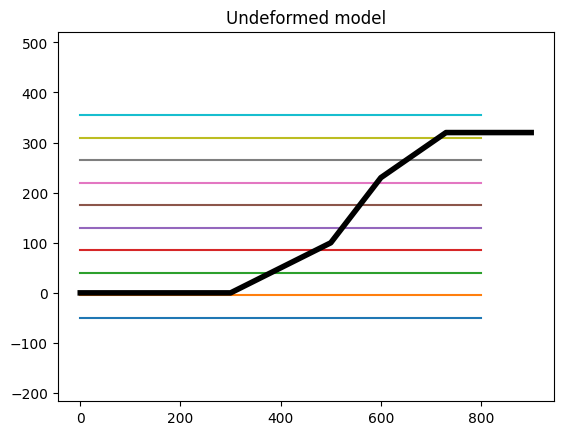

In [15]:
#Drawing of the undeformed model

print('\033[1m' +'\033[3m'+ 'Figure 2')
drawFigure("Undeformed model")


***Figure 3***

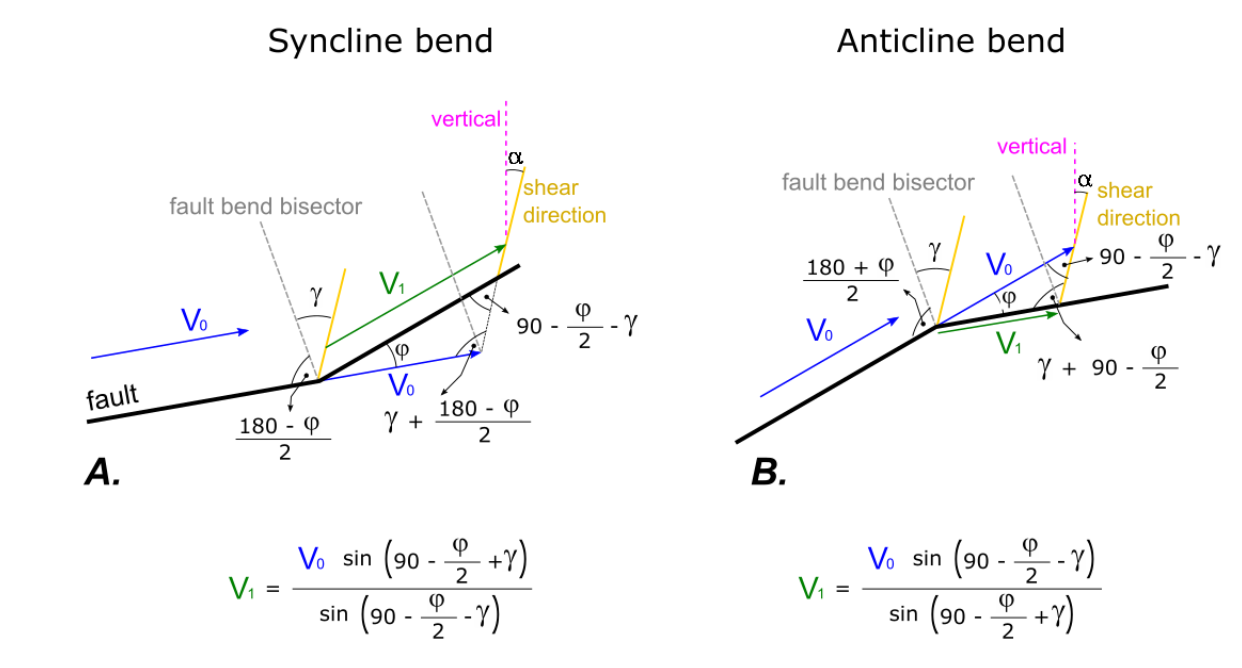

In [16]:
#Calculated Velocities in non-trishear panels

#In this cell the velocity of the non-trishear panels are calculated.
#Each velocity is calculated with respect to the previous panel based on the asymmetry of the axial line with respect to the bisector of the fault bend.


Velocities=[]
Velocities.append(stepSlip)
print("See figure 1 for reference")
print(" ")
print ("V0=", stepSlip)
for i in range (1,len(F_x)-1):
  bend_sign=np.sign(((F_y[i+1]-F_y[i])/(F_x[i+1]-F_x[i]))-((F_y[i]-F_y[i-1])/(F_x[i]-F_x[i-1]))) #Positive value indicates syncline bend of the fault. Negative value indicates anticline bend of the fault.

  Velocities.append(Velocities[i-1]*np.sin((np.pi/2)-(Phi_rad[i]/2)+Gamma_rad[i]*bend_sign) / np.sin((np.pi/2)-(Phi_rad[i]/2)-Gamma_rad[i]*bend_sign)) #See equation in previous figure 3

  vel="V"+str(i)+"="
  print (vel, Velocities[i])




See figure 1 for reference
 
V0= 2
V1= 2.0
V2= 2.1688020744870884
V3= 2.2288319840969346
V4= 1.7737549063530582


***BLTR (back-limb trishear) classes***

In [17]:
#This class makes the transformation of coordinates from model (geographic) to the BLTR system
class transform_geo_2_trishear(object):
     def __init__(self,pointNumber,x_old, y_old):
      x_old=x_old-F_x[pointNumber]
      y_old=y_old-F_y[pointNumber]

      #Transformation matrix from model (geographic) to fault system
      Transformation_fault_1_1=np.cos(np.arctan((F_y[pointNumber+1]-F_y[pointNumber])/(F_x[pointNumber+1]-F_x[pointNumber])))
      Transformation_fault_1_2=np.cos((np.pi/2)-np.arctan((F_y[pointNumber+1]-F_y[pointNumber])/(F_x[pointNumber+1]-F_x[pointNumber])))
      Transformation_fault_2_1=np.cos((np.pi/2)+np.arctan((F_y[pointNumber+1]-F_y[pointNumber])/(F_x[pointNumber+1]-F_x[pointNumber])))
      Transformation_fault_2_2=Transformation_fault_1_1

      #Transformation from model (geographic) to fault system
      x_falla=x_old*Transformation_fault_1_1+y_old*Transformation_fault_1_2
      y_falla=x_old*Transformation_fault_2_1+y_old*Transformation_fault_2_2

      bend_sign=np.sign(((F_y[pointNumber+1]-F_y[pointNumber])/(F_x[pointNumber+1]-F_x[pointNumber]))-((F_y[pointNumber]-F_y[pointNumber-1])/(F_x[pointNumber]-F_x[pointNumber-1]))) #Positive value indicates syncline bend of the fault. Negative value indicates anticline bend of the fault.

      bisector=(np.pi-Phi_rad[pointNumber]*bend_sign)/2

      bisector_asymetry=bisector-Gamma_rad[pointNumber]

      #Transformation matrix from fault to BLTR system
      Transformation_trish_1_1=np.cos(bisector_asymetry)
      Transformation_trish_1_2=np.cos((np.pi/2)-bisector_asymetry)
      Transformation_trish_2_1=np.cos((np.pi/2)+bisector_asymetry)
      Transformation_trish_2_2=Transformation_trish_1_1

      #Transformation from fault to BLTR system
      x_trish=x_falla*Transformation_trish_1_1+y_falla*Transformation_trish_1_2
      y_trish=x_falla*Transformation_trish_2_1+y_falla*Transformation_trish_2_2

      self.x=x_trish
      self.y=y_trish


In [18]:
#This class makes the transformation of coordinates from BLTR to model (geographic) system
class transform_trishear_2_geo(object):
     def __init__(self,pointNumber,x_old, y_old):
      bend_sign=np.sign(((F_y[pointNumber+1]-F_y[pointNumber])/(F_x[pointNumber+1]-F_x[pointNumber]))-((F_y[pointNumber]-F_y[pointNumber-1])/(F_x[pointNumber]-F_x[pointNumber-1]))) #Positive value indicates syncline bend of the fault. Negative value indicates anticline bend of the fault.

      bisector=(np.pi-Phi_rad[pointNumber]*bend_sign)/2
      bisector_asymetry=bisector-Gamma_rad[pointNumber]

      #Transformation matrix from BLTR to fault system
      Transformation_trish_1_1=np.cos(bisector_asymetry)
      Transformation_trish_1_2=np.cos((np.pi/2)-bisector_asymetry)
      Transformation_trish_2_1=np.cos((np.pi/2)+bisector_asymetry)
      Transformation_trish_2_2=Transformation_trish_1_1

      #Transformation from BLTR to fault system
      x_new=x_old*Transformation_trish_1_1+y_old*Transformation_trish_2_1
      y_new=x_old*Transformation_trish_1_2+y_old*Transformation_trish_2_2

      #Transformation matrix from fault to model (geographic) system
      Transformation_fault_1_1=np.cos(np.arctan((F_y[pointNumber+1]-F_y[pointNumber])/(F_x[pointNumber+1]-F_x[pointNumber])))
      Transformation_fault_1_2=np.cos((np.pi/2)-np.arctan((F_y[pointNumber+1]-F_y[pointNumber])/(F_x[pointNumber+1]-F_x[pointNumber])))
      Transformation_fault_2_1=np.cos((np.pi/2)+np.arctan((F_y[pointNumber+1]-F_y[pointNumber])/(F_x[pointNumber+1]-F_x[pointNumber])))
      Transformation_fault_2_2=Transformation_fault_1_1

      #Transformation from fault to model (geographic) system
      x_new_new=x_new*Transformation_fault_1_1+y_new*Transformation_fault_2_1
      y_new_new=x_new*Transformation_fault_1_2+y_new*Transformation_fault_2_2


      x_new_new=x_new_new+F_x[pointNumber]
      y_new_new=y_new_new+F_y[pointNumber]

      self.x=x_new_new
      self.y=y_new_new

In [19]:
#This class computes the velocity for each point within the BLTR zone
#input and output points are in BLTR system
class BLTR(object):
     def __init__(self,pointNumber,x_old, y_old):

      Vbefore=Velocities[pointNumber-1]
      Vafter=Velocities[pointNumber]

      #velocity vectors directions
      v0 = np.array([F_x[pointNumber]-F_x[pointNumber-1], F_y[pointNumber]-F_y[pointNumber-1]])
      v1 = np.array([F_x[pointNumber+1]-F_x[pointNumber], F_y[pointNumber+1]-F_y[pointNumber]])

      #normalized velocity vectors
      v0_norm = v0 / np.linalg.norm(v0)
      v1_norm = v1 / np.linalg.norm(v1)

      #velocity vectors with their modules
      Vbefore_vector=Vbefore*v0_norm
      Vafter_vector=Vafter*v1_norm

      #velocity vectors changing the reference center to fault bend point
      Vbefore_vector[0]=Vbefore_vector[0]+F_x[pointNumber]
      Vbefore_vector[1]=Vbefore_vector[1]+F_y[pointNumber]
      Vafter_vector[0]=Vafter_vector[0]+F_x[pointNumber]
      Vafter_vector[1]=Vafter_vector[1]+F_y[pointNumber]

      #transformation of velocity vector to BLTR system
      Vbefore_vector_BLTR=transform_geo_2_trishear(pointNumber,Vbefore_vector[0],Vbefore_vector[1])
      Vafter_vector_BLTR=transform_geo_2_trishear(pointNumber,Vafter_vector[0],Vafter_vector[1])

      V0x=Vbefore_vector_BLTR.x
      V0y=Vbefore_vector_BLTR.y
      V1x=Vafter_vector_BLTR.x
      V1y=Vafter_vector_BLTR.y

      #BLTR equations. See Cristallini and Allmendinger (2002)
      VBLTRx=(V0x/2)*((y_old/(x_old*np.tan(Psi_rad[pointNumber])))+1)+(V1x/2)* ((-y_old/(x_old*np.tan(Psi_rad[pointNumber])))+1)
      C=(V1x-V0x)*((np.sign(y_old)/(4*np.tan(Psi_rad[pointNumber])))*((abs(y_old)/x_old)**2))-V0y
      VBLTRy=(V0x-V1x)*((np.sign(y_old)/(4*np.tan(Psi_rad[pointNumber])))*((abs(y_old)/x_old)**2)) +C

      self.x=x_old+VBLTRx
      self.y=y_old-VBLTRy


***Model classes***

In [20]:
#This class create polygons for each panel of the system (see figure 1)
#Non-trishear polygons are named with the number of the forward bend point.
#For example panel 0 is to the left of fault bend 1. And panel 1 to the right of fault bend 2
#Trishear panels are named with 10+i. Where i is the fault bend where the BLTR has the apex.
#For example, the BLTR with apex in fault bend 1 is names 11

class create_polygons(object):
     def __init__(self):

      #Footwall panel

      pointList=[]
      for i in range (0,len(F_x)):
        pointList.append(Point(F_x[i], F_y[i]))

      pointList.append(Point(F_x[len(F_x)-1], model_bottom))
      pointList.append(Point(F_x[0], model_bottom))

      self.footwall_polygon=Polygon([[p.x, p.y] for p in pointList]) #Footwall panel

      #Hangingwall panels

      panels=[]
      panels_BLTR=[]

      bisector_old=np.array([F_x[0], model_top])

      for i in range (1,len(F_x)-1):
        bend_sign=np.sign(((F_y[i+1]-F_y[i])/(F_x[i+1]-F_x[i]))-((F_y[i]-F_y[i-1])/(F_x[i]-F_x[i-1]))) #Positive value indicates syncline bend of the fault. Negative value indicates anticline bend of the fault.

        bisector=fault_bisector(i).bisector

        bisector_angle = np.arctan2(bisector[1], bisector[0]) # Be careful, it is correct that the y x coordinates are inverted

        # BLTR boundary angles
        totalAngle_1=bisector_angle-Gamma_rad[i]+Psi_rad[i]
        totalAngle_2=bisector_angle-Gamma_rad[i]-Psi_rad[i]

        # BLTR boundary vectors normalized
        totalAngle_vector_1=np.array([np.cos(totalAngle_1), np.sin(totalAngle_1)])
        totalAngle_vector_2=np.array([np.cos(totalAngle_2), np.sin(totalAngle_2)])

         # BLTR boundary vectors
        totalAngle_vector_1=totalAngle_vector_1*model_top*bend_sign
        totalAngle_vector_1[0]=totalAngle_vector_1[0]+F_x[i]
        totalAngle_vector_1[1]=totalAngle_vector_1[1]+F_y[i]

        totalAngle_vector_2=totalAngle_vector_2*model_top*bend_sign
        totalAngle_vector_2[0]=totalAngle_vector_2[0]+F_x[i]
        totalAngle_vector_2[1]=totalAngle_vector_2[1]+F_y[i]

         # Non-trishear point list
        pointList.clear
        pointList.append(Point(F_x[i-1], F_y[i-1]))
        pointList.append(Point(F_x[i], F_y[i]))
        pointList.append(Point(totalAngle_vector_1[0], totalAngle_vector_1[1]))
        pointList.append(Point(bisector_old[0], bisector_old[1]))

        # Non-trishear polygon
        panels.append(Polygon([[p.x, p.y] for p in pointList]))

         # BLTR point list
        pointList.clear()
        pointList.append(Point(F_x[i], F_y[i]))
        pointList.append(Point(totalAngle_vector_1[0], totalAngle_vector_1[1]))
        pointList.append(Point(totalAngle_vector_2[0], totalAngle_vector_2[1]))

        # BLTR polygon
        panels_BLTR.append(Polygon([[p.x, p.y] for p in pointList]))

        bisector_old=totalAngle_vector_2 # it is going to be used in next panel

        pointList.clear()

      self.panels=panels
      self.panels_BLTR=panels_BLTR





Figure 4


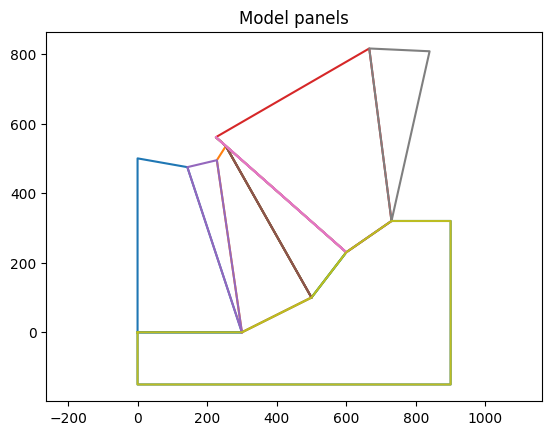

In [21]:
#This cell draw the different panels of the model
footwall_polygon=Polygon(None)

polygons=create_polygons()
footwall_polygon=polygons.footwall_polygon
panels=polygons.panels
panels_BLTR=polygons.panels_BLTR

for panel in panels:
  x,y = panel.exterior.xy
  plt.plot(x,y)

for panel in panels_BLTR:
  x,y = panel.exterior.xy
  plt.plot(x,y)

x,y = footwall_polygon.exterior.xy
plt.plot(x,y)

plt.axis('equal')
plt.title("Model panels")

print('\033[1m' +'\033[3m'+ 'Figure 4')
plt.show()


In [22]:
#This class return the name of the panel where a point is

class evaluate_position(object):
     def __init__(self,x, y,footwall_polygon,panels,panels_BLTR):
      zona=len(F_x)-2 #last zone

      point = Point(x, y)

      if footwall_polygon.contains(point)==True: #Evaluate if the point is in the footwall (result -1)
        zona=-1
      else: #Evaluate if the point is in one of the non-trishear panels
        for i in range (0,len(panels)):
          if (panels[i].contains(point)):
            zona=i
            break
        else: #Evaluate if the point is in one of the BLTR panels
          for i in range (0,len(panels_BLTR)):
            if (panels_BLTR[i].contains(point)):
              zona=i+11 #ya que BLTR zona 0 no existe
              break

      self.resultado=zona


***Model execution***

In [23]:
#This run the model and produce the deformation

for s in range (0,totalSlip,stepSlip):
  for bb in  bedd:
    for i in range (0,len(bb.x)):
      a=evaluate_position(bb.x[i],bb.y[i],footwall_polygon,panels,panels_BLTR)
      if a.resultado!=-1: #If the point is not in the footwall
        if a.resultado<10: #If the point is in one of the non-trishear panells
          vector = np.array([F_x[a.resultado+1]-F_x[a.resultado], F_y[a.resultado+1]-F_y[a.resultado]]) #Movement vector direction
          vector_norm = vector / np.linalg.norm(vector) #Normalized movement vector
          vector_vel=vector_norm*Velocities[a.resultado]*np.cos(Phi_rad[a.resultado]) #Movement vector

          bb.x[i]=bb.x[i]+vector_vel[0] #Moving point
          bb.y[i]=bb.y[i]+vector_vel[1]
        else: #If the point is in one of the BLTR panells

          index=a.resultado-10 #Remember the panel nomenclature

          trish_coor=transform_geo_2_trishear(index,bb.x[i],bb.y[i]) #Transform point to BLTR coordinate system

          point_moved_BLTR=BLTR(index,trish_coor.x,trish_coor.y) #Apply BLTR equations

          fault_coor=transform_trishear_2_geo(index,point_moved_BLTR.x,point_moved_BLTR.y) #Transform point to model (geographyc) coordinate system

          bb.x[i]=fault_coor.x
          bb.y[i]=fault_coor.y



Figure 5


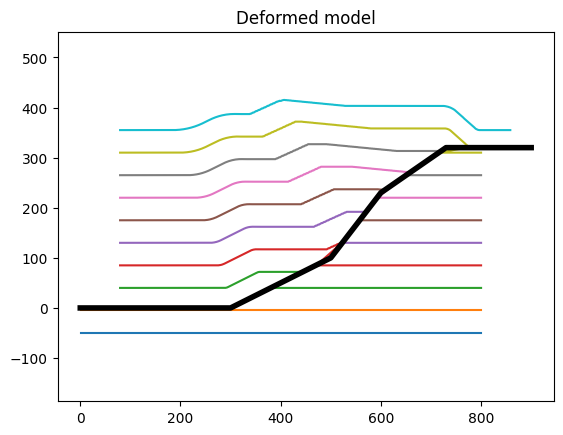

In [24]:
#Drawing of the deformed model

print('\033[1m' +'\033[3m'+ 'Figure 5')
drawFigure("Deformed model")